<a href="https://colab.research.google.com/github/Kenicki/Kenicki/blob/main/Diabetes_mlops_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tempfile
import os
%matplotlib inline

In [32]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [34]:

import pandas as pd
import seaborn as sns
import missingno as msno
from google.colab import drive

In [35]:

#mount drive to import dataset from google drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [36]:
# import dataset
df= pd.read_csv('/content/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [37]:

#export dataframe as raw_data
df.to_csv("raw_data.csv",index=False)

In [38]:

#login to wandb
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [39]:
# Send the raw_data.csv to the Wandb storing it as an artifact
!wandb artifact put \
      --name ddiabetes_decision_tree/raw_data.csv \
      --type raw_data \
      --description "The raw data from prima indians" raw_data.csv

wandb: Uploading file raw_data.csv to: "chegenkelvin-kenickilive/ddiabetes_decision_tree/raw_data.csv:latest" (raw_data)
wandb: Currently logged in as: chegenkelvin (chegenkelvin-kenickilive) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /content/wandb/run-20250623_163126-3w00lo1a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run autumn-river-1
wandb: ⭐️ View project at https://wandb.ai/chegenkelvin-kenickilive/ddiabetes_decision_tree
wandb: 🚀 View run at https://wandb.ai/chegenkelvin-kenickilive/ddiabetes_decision_tree/runs/3w00lo1a
wandb: ⢿ uploading artifact raw_data.csv (0.9s)
wandb: ⣻ uploading artifact raw_data.csv (0.9s)
wandb: ⣽ uploading artifact raw_data.csv (0.9s)
wandb:                                                                                
wandb: ⣽ uploading artifact raw_data.csv (0.9s)
wandb: 🚀 View run autumn-river-1 at: https://wandb.ai/cheg

In [40]:

# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project="diabetes_decision_tree", save_code=True)

wandb: Currently logged in as: chegenkelvin (chegenkelvin-kenickilive) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [43]:
# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact("ddiabetes_decision_tree/raw_data.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

In [44]:

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [45]:
# prompt: df.info()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [46]:

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [47]:

# There are duplicated rows
df.duplicated().sum()

np.int64(0)

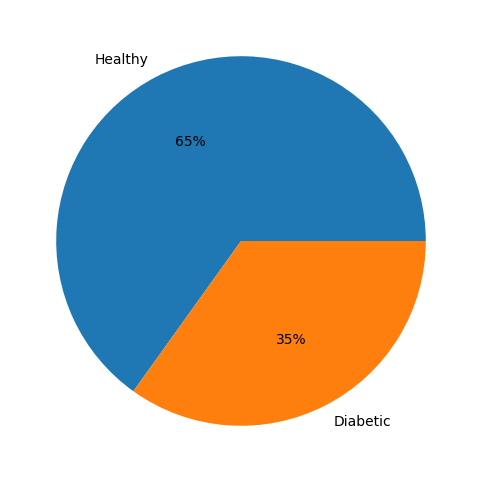

In [48]:
# Is data balanced?
plt.figure(figsize=(6,6))
labels = ['Healthy','Diabetic']
values = [df.Outcome.value_counts()[0], df.Outcome.value_counts()[1]]
plt.pie(values, labels=labels,autopct = '%0.0f%%')
plt.show()

<Axes: >

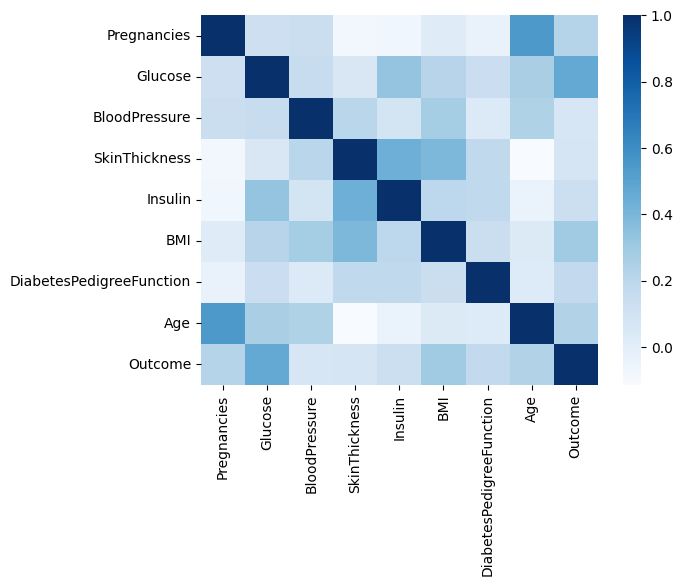

In [49]:

# Correlation
sns.heatmap(df.corr(),cmap='Blues',annot=False)

<Axes: >

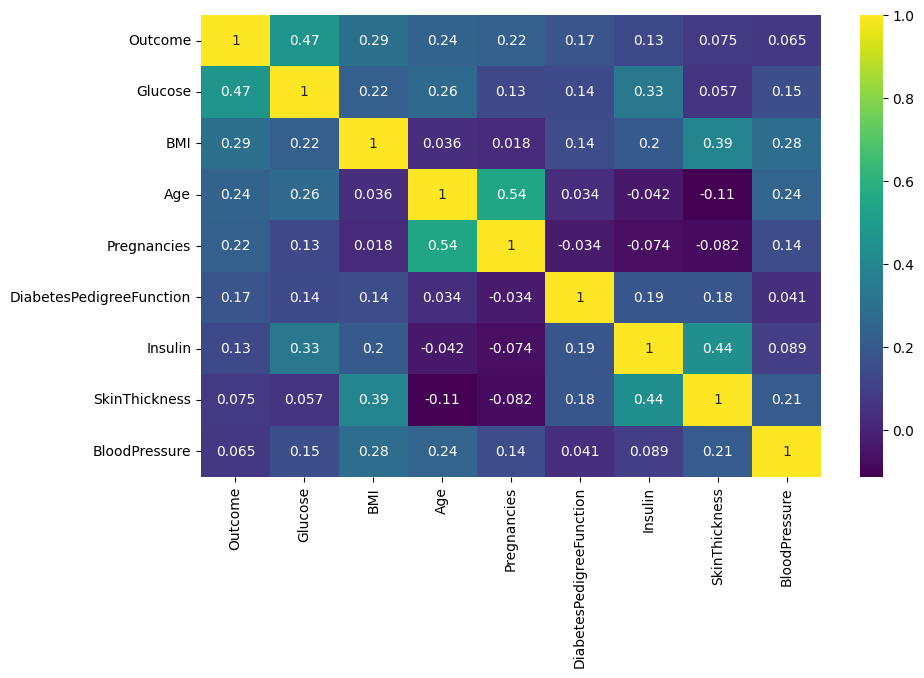

In [50]:
#Outcome correlation matrix
k = 9 #number of variables for heatmap
cols = df.corr().nlargest(k, 'Outcome')['Outcome'].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

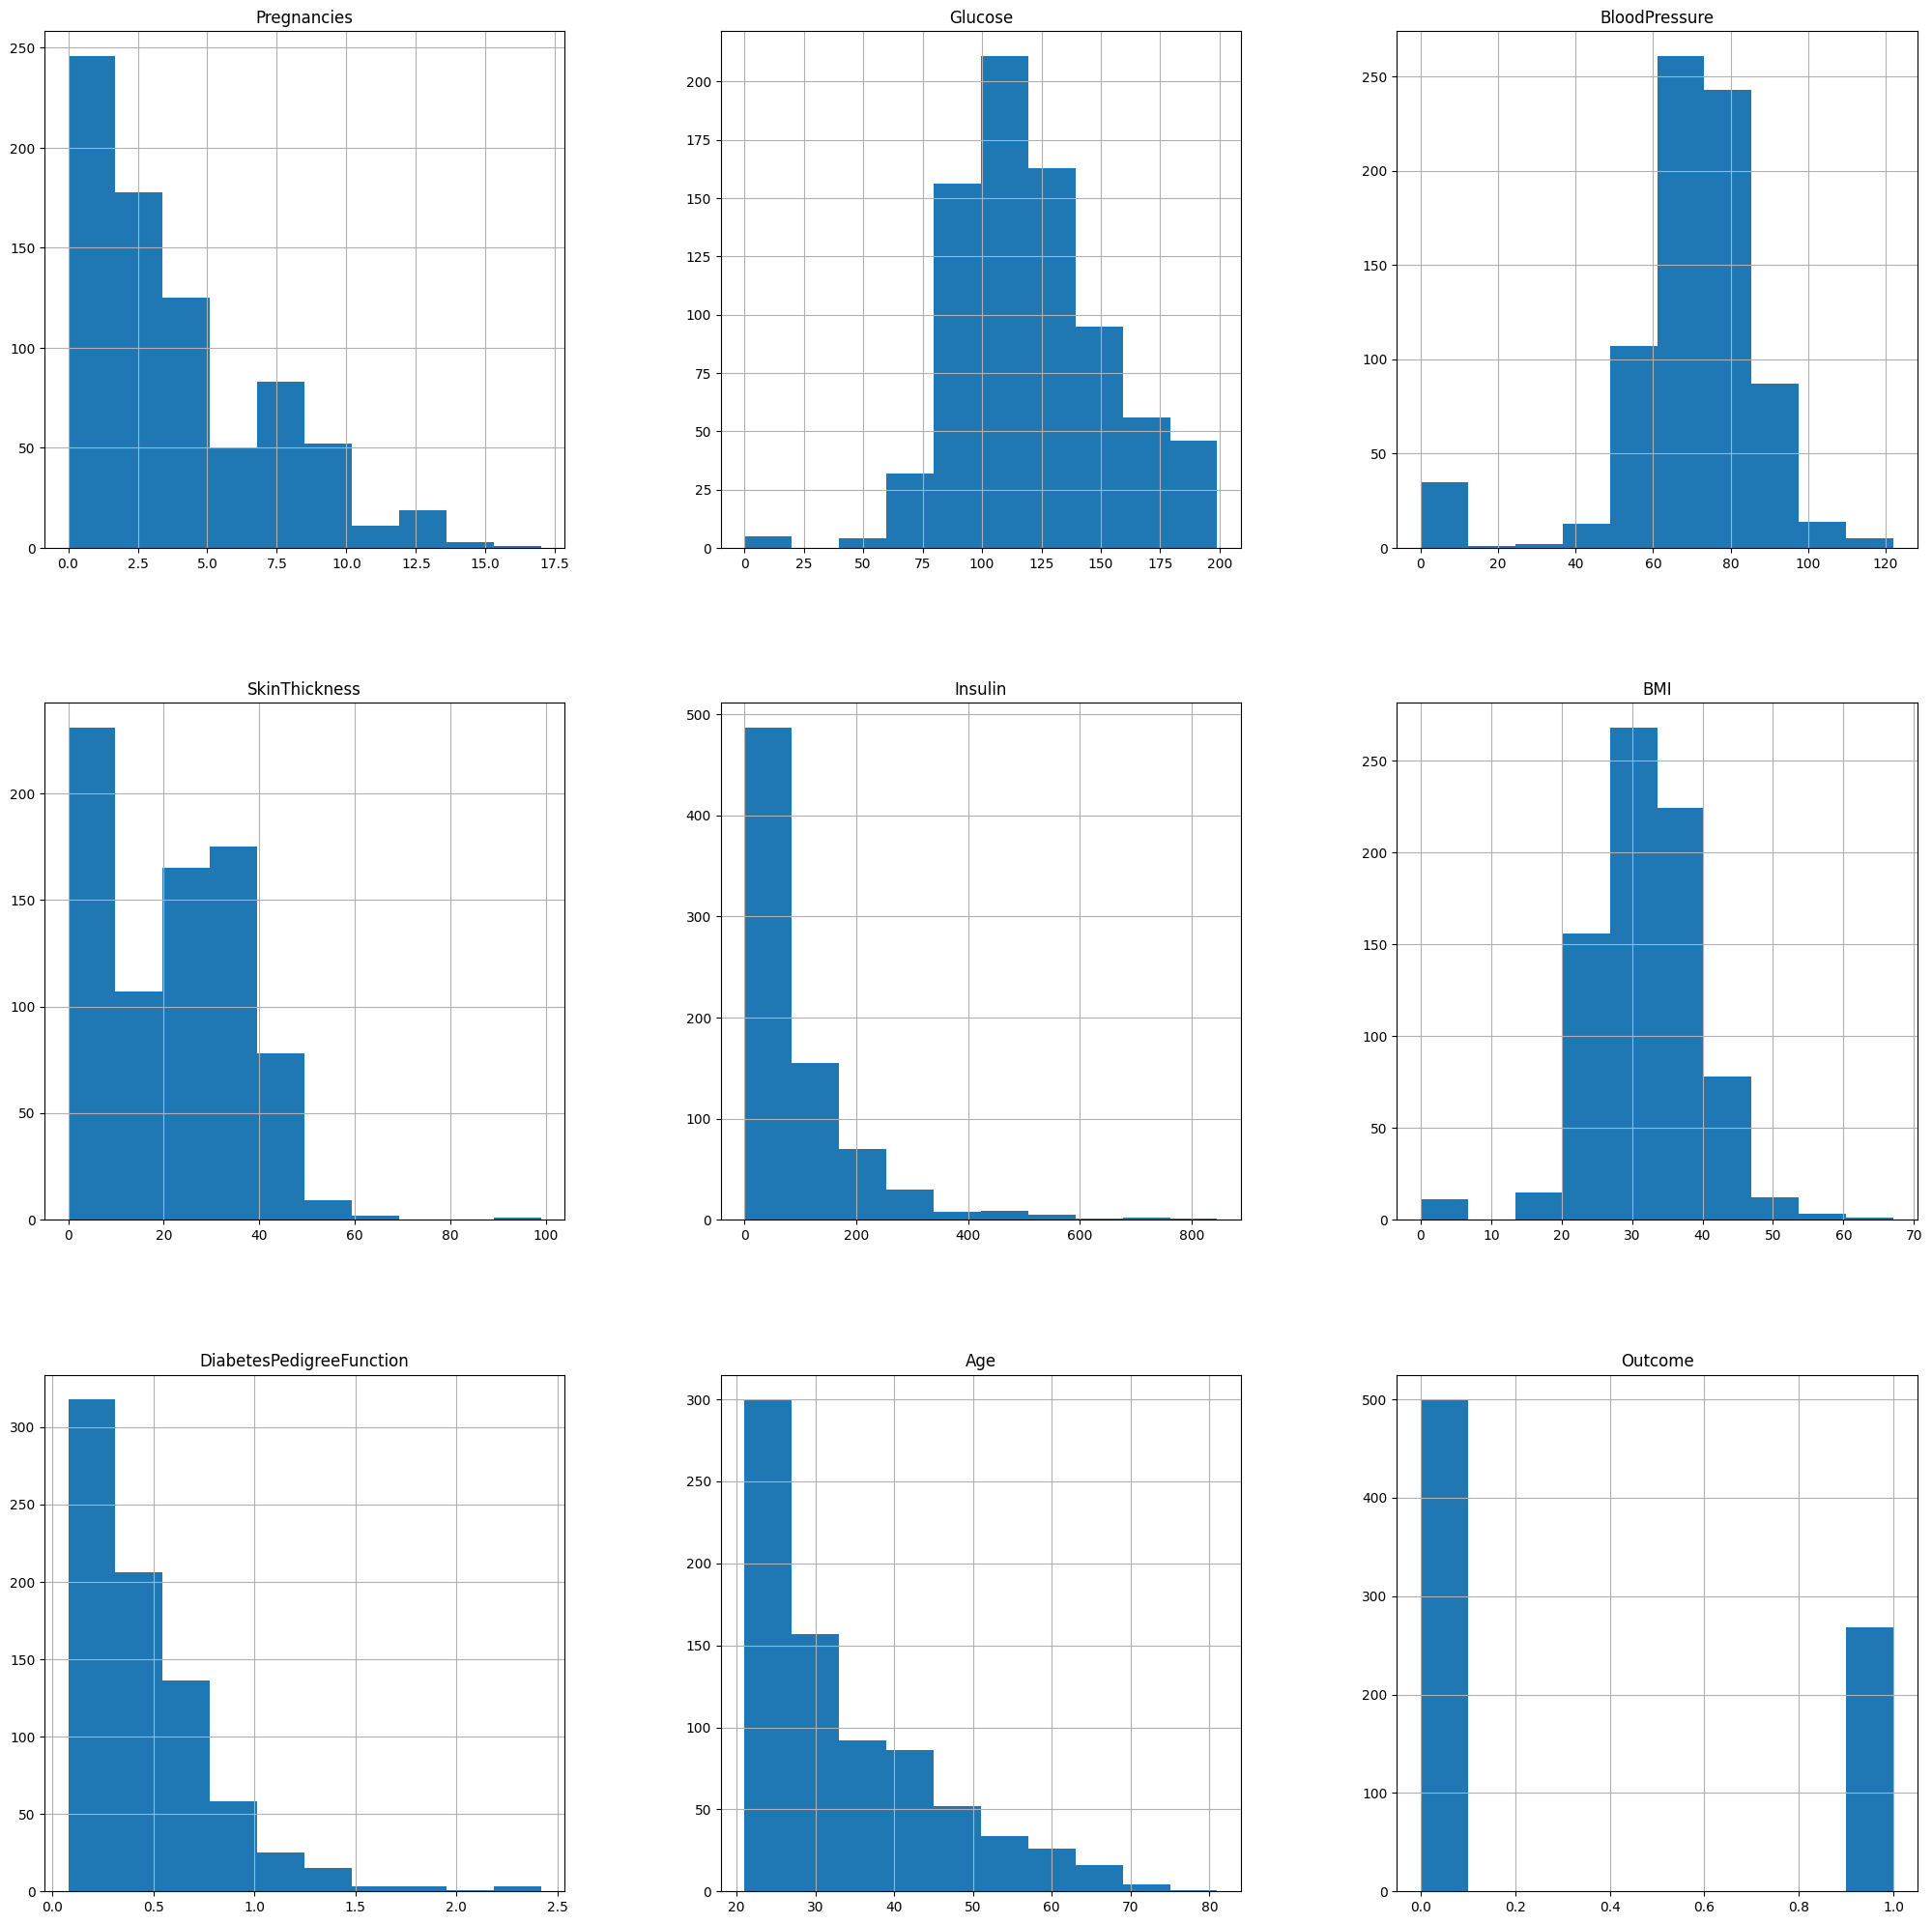

In [60]:
# How the data is distributed.
fig = df.hist(figsize = (25,25))
plt.savefig('featureHist.png',dpi=300)
run.log(
        {
            "FeaturesHist": wandb.Image("featureHist.png")
        }
        )

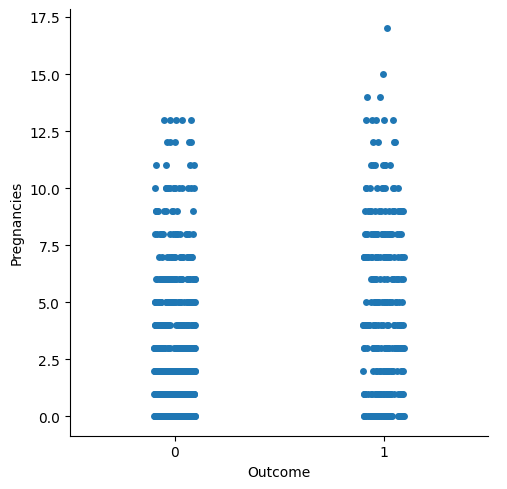

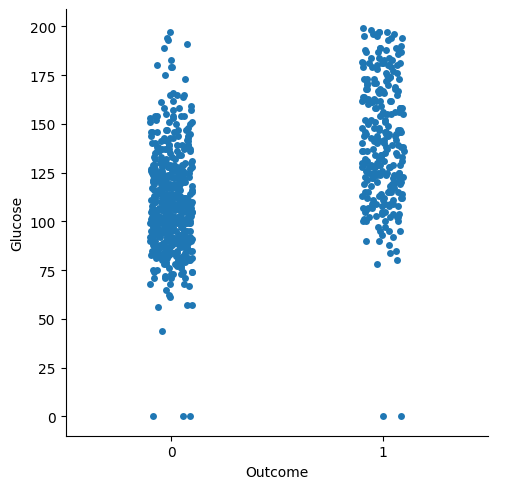

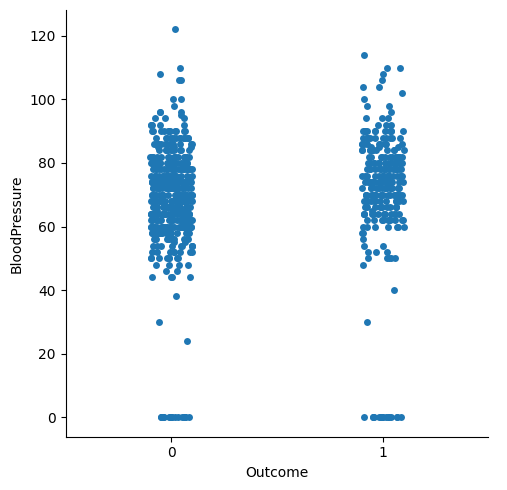

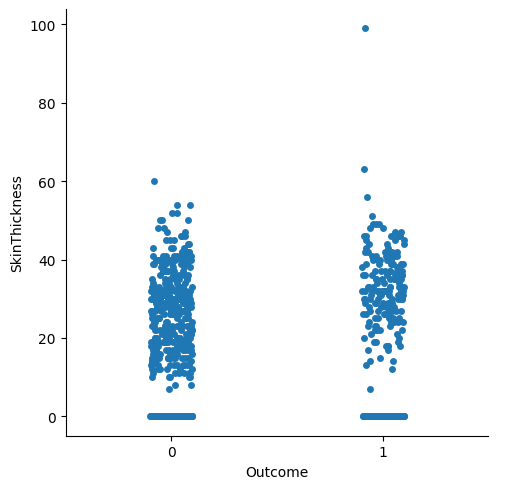

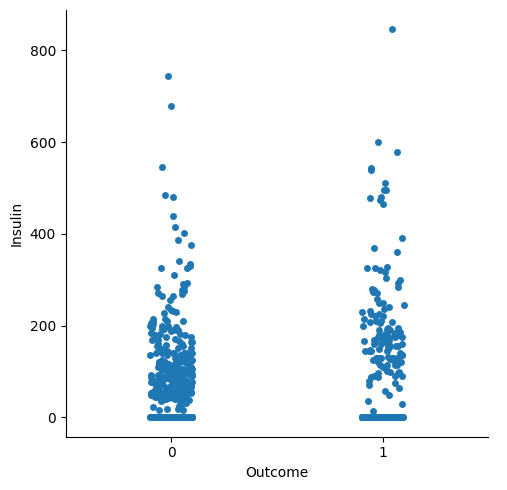

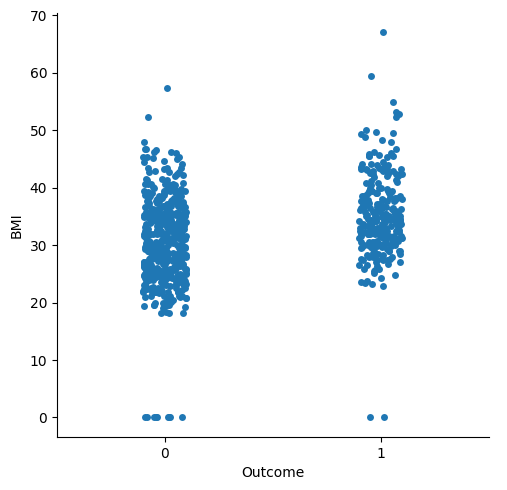

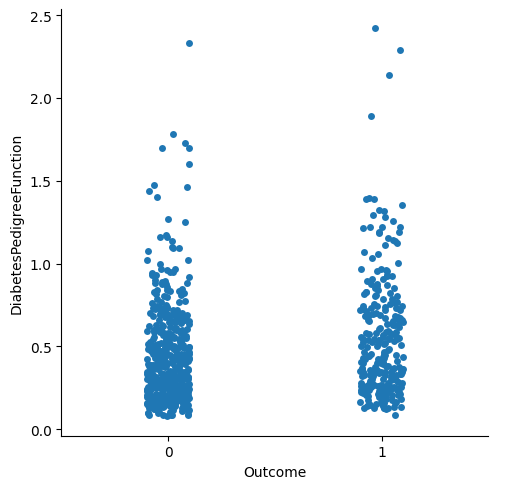

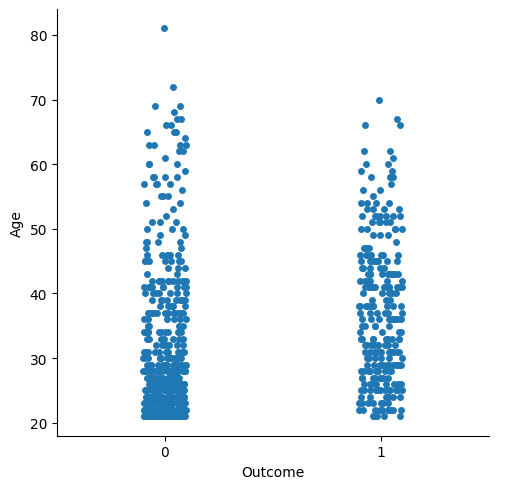

In [56]:
for col in df.columns:
    if col != "Outcome":
        sns.catplot(x="Outcome", y=col, data=df)

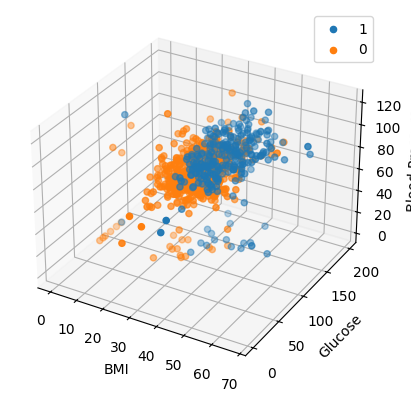

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in df.Outcome.unique():
    ax.scatter(df.BMI[df.Outcome==s],df.Glucose[df.Outcome==s],df.BloodPressure[df.Outcome==s],label=s)
ax.legend()
ax.set_xlabel('BMI')
ax.set_ylabel('Glucose')
ax.set_zlabel('Blood Pressure')

ax.figure.savefig('BMIxGlucosexBloodPressure.png', dpi=300)

Running a test file


In [63]:

%%file test_data.py
import pytest
import wandb
import pandas as pd

Writing test_data.py


In [64]:
# This is global so all tests are collected under the same run
run = wandb.init(project="diabetes_decision_tree", job_type="data_checks")


In [69]:
@pytest.fixture(scope="session")
def data():

    local_path = run.use_artifact("diabetes_decision_tree/preprocessed_data.csv:latest").file()
    df = pd.read_csv(local_path)

    return df

def test_data_length(data):
    """
    We test that we have enough data to continue
    """
    assert len(data) > 500


def test_number_of_columns(data):
    """
    We test that we have enough data to continue
    """
    assert data.shape[1] == 9

def test_column_presence_and_type(data):

    required_columns = {
        "Pregnancies": pd.api.types.is_int64_dtype,
        "Glucose": pd.api.types.is_int64_dtype,
        "BloodPressure": pd.api.types.is_int64_dtype,
        "SkinThickness": pd.api.types.is_int64_dtype,
        "Insulin": pd.api.types.is_int64_dtype,
        "BMI": pd.api.types.is_float_dtype,
        "DiabetesPedigreeFunction": pd.api.types.is_float_dtype,
        "Age": pd.api.types.is_int64_dtype,
        "Outcome": pd.api.types.is_int64_dtype
    }

    # Check column presence
    assert set(data.columns.values).issuperset(set(required_columns.keys()))

    for col_name, format_verification_funct in required_columns.items():

        assert format_verification_funct(data[col_name]), f"Column {col_name} failed test {format_verification_funct}"


def test_class_names(data):

    # Check that only the known classes are present
    known_classes = [0,1]

    assert data["Outcome"].isin(known_classes).all()


def test_column_ranges(data):

    ranges = {
        "Age": (18, 90)
    }

    for col_name, (minimum, maximum) in ranges.items():

        assert data[col_name].dropna().between(minimum, maximum).all(), (
            f"Column {col_name} failed the test. Should be between {minimum} and {maximum}, "
            f"instead min={data[col_name].min()} and max={data[col_name].max()}"
        )

In [70]:
!pytest . -vv

Test session starts (platform: linux, Python 3.11.13, pytest 8.3.5, pytest-sugar 1.0.0)
cachedir: .pytest_cache
rootdir: /content
plugins: sugar-1.0.0, langsmith-0.3.45, typeguard-4.4.3, anyio-4.9.0
collected 0 items                                                              


Results (2.17s):


In [71]:

import wandb
import pandas as pd
import numpy as np
import tempfile
import logging
import os

In [72]:

input_artifact="diabetes_decision_tree/raw_data.csv:latest"
artifact_name="preprocessed_data.csv"
artifact_type="clean_data"
artifact_description="Data after preprocessing"

In [73]:

# create a new job_type
run = wandb.init(project="diabetes_decision_tree", job_type="process_data")

In [75]:
# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact("ddiabetes_decision_tree/raw_data.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

In [76]:

# Delete duplicated rows
df.drop_duplicates(inplace=True)

# Generate a "clean data file"
df.to_csv(artifact_name,index=False)

In [77]:

#df['New_Glucose_Class'] = pd.cut(x=df['Glucose'], bins=[0,139,200],labels = ["Normal","Prediabetes"])
#df['New_BMI_Range'] = pd.cut(x=df['BMI'], bins=[0,18.5,24.9,29.9,100],labels = ["Underweight","Healty","Overweight","Obese"])
#df['New_BloodPressure'] = pd.cut(x=df['BloodPressure'], bins=[0,79,89,123],labels = ["Normal","HS1","HS2"])
#df['New_SkinThickness'] = df['SkinThickness'].apply(lambda x: 1 if x <= 18.0 else 0)
df['New_BMI_Range'] = np.where(df['BMI'] < 18.5, "Underweight", np.where(df['BMI'] < 24.9, "Healty", np.where(df['BMI'] < 29.9, "Overweight", "Obese")))
df['New_Glucose_Class'] = np.where(df['Glucose'] < 139, "Normal", "Prediabetes")
df['New_BloodPressure'] = np.where(df['BloodPressure'] < 79, "Normal", np.where(df['BloodPressure'] < 89, "HS1", "HS2"))
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_BMI_Range,New_Glucose_Class,New_BloodPressure
0,6,148,72,35,0,33.6,0.627,50,1,Obese,Prediabetes,Normal
1,1,85,66,29,0,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Healty,Prediabetes,Normal
3,1,89,66,23,94,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Obese,Normal,Normal


In [78]:

df.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64
New_BMI_Range,object


In [79]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

In [80]:

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_BMI_Range,New_Glucose_Class,New_BloodPressure
0,6,148,72,35,0,33.6,0.627,50,1,Obese,Prediabetes,Normal
1,1,85,66,29,0,26.6,0.351,31,0,Overweight,Normal,Normal
2,8,183,64,0,0,23.3,0.672,32,1,Healty,Prediabetes,Normal
3,1,89,66,23,94,28.1,0.167,21,0,Overweight,Normal,Normal
4,0,137,40,35,168,43.1,2.288,33,1,Obese,Normal,Normal


In [81]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()
with tempfile.TemporaryDirectory() as tmp_dir:
        temp_path = os.path.join(tmp_dir, artifact_name)
        df.to_csv(temp_path,index=False)

        artifact = wandb.Artifact(name=artifact_name,
                                  type=artifact_type,
                                  description="pre processed data",
        )

        artifact.add_file(temp_path)

        logger.info("Logging artifact")
        run.log_artifact(artifact)

        # This waits for the artifact to be uploaded to W&B. If you
        # do not add this, the temp directory might be removed before
        # W&B had a chance to upload the datasets, and the upload
        # might fail
        artifact.wait()

In [82]:

# Upload the artifact to Wandb
run.log_artifact(artifact)

<Artifact QXJ0aWZhY3Q6MTgzMTg4MDc5Nw==>

In [83]:
# close the run
# waiting a while after run the previous cell before execute this
run.finish()


In [84]:

import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [85]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]


# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # chage values = 0 from some columns
        i = 0
        for col in df.keys():
            if col != 'Pregnancies':
                a = df[col]
                a = a[a != 0]
                a_mean = round(a.median())
                print(col,a_mean)
                df[col].replace(0,a_mean,inplace=True)
                a_mean = 0

        # update columns name


        self.colnames = df.columns.tolist()
        aaa = df.copy()
        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        #df = pd.DataFrame(df, columns=self.colnames)

        return df

# transform float features
class FloatTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # chage values = 0 from some columns
        for col in df.keys():
            a = df[col]
            a = a[a != 0]
            a_mean = round(a.median(),1)
            df[col].replace(0,a_mean,inplace=True)

        # update columns name
        self.colnames = df.columns.tolist()
        aaa = df.copy()
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df


In [86]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "diabetes_decision_tree/test.csv:latest"

# name of the model artifact
artifact_model_name = "diabetes_decision_tree/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "diabetes_decision_tree/target_encoder:latest"

In [87]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()


In [88]:
# initiate the wandb project
run = wandb.init(project="diabetes_decision_tree",job_type="test")

In [90]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact("diabetes_decision_tree/preprocessed_data.csv:latest").file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("Outcome")

In [91]:

# Takes a look at test set
x_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,New_BMI_Range,New_Glucose_Class,New_BloodPressure
0,6,148,72,35,0,33.6,0.627,50,Obese,Prediabetes,Normal
1,1,85,66,29,0,26.6,0.351,31,Overweight,Normal,Normal
2,8,183,64,0,0,23.3,0.672,32,Healty,Prediabetes,Normal
3,1,89,66,23,94,28.1,0.167,21,Overweight,Normal,Normal
4,0,137,40,35,168,43.1,2.288,33,Obese,Normal,Normal


In [92]:
# Take a look at the target variable
y_test.head()

,Outcome
0,1
1,0
2,1
3,0
4,1


In [94]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

CommError: artifact 'target_encoder:latest' not found in 'chegenkelvin-kenickilive/diabetes_decision_tree'

In [97]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

UsageError: Run (ht0624lp) is finished. The call to `use_artifact` will be ignored. Please make sure that you are using an active run.

**Note:** The following cells are placeholders to create a dummy `target_encoder` artifact so that the testing workflow can proceed without the `CommError`. In a real project, you would have a model training step here that trains your model and saves the actual target encoder used.

In [95]:
# Placeholder: Simulate model training and saving a target encoder
# In a real scenario, replace this with your actual training code

from sklearn.preprocessing import LabelEncoder
import joblib
import os
import tempfile

# Create a dummy label encoder
le = LabelEncoder()
# Fit it on some dummy data (replace with your actual target data if needed)
dummy_target_data = ['class_a'] * 10 + ['class_b'] * 10
le.fit(dummy_target_data)

# Define artifact details
artifact_encoder_name = "target_encoder" # Use the base name without version
artifact_type = "label_encoder"
artifact_description = "Dummy target encoder artifact for testing"

# Initialize a new run for this placeholder step (job_type="train")
# In a real scenario, this would be your actual training run
run_placeholder = wandb.init(project="diabetes_decision_tree", job_type="train")

# Save the dummy encoder to a temporary file
with tempfile.TemporaryDirectory() as tmp_dir:
    encoder_filepath = os.path.join(tmp_dir, "target_encoder.joblib")
    joblib.dump(le, encoder_filepath)

    # Create and log the artifact
    artifact = wandb.Artifact(
        name=artifact_encoder_name,
        type=artifact_type,
        description=artifact_description
    )
    artifact.add_file(encoder_filepath)

    print(f"Logging dummy artifact '{artifact_encoder_name}'...")
    run_placeholder.log_artifact(artifact)
    artifact.wait() # Wait for the artifact to be uploaded

print("Dummy target encoder artifact logged successfully.")

# Finish the placeholder run
run_placeholder.finish()

Logging dummy artifact 'target_encoder'...
Dummy target encoder artifact logged successfully.


In [96]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

UsageError: Run (ht0624lp) is finished. The call to `use_artifact` will be ignored. Please make sure that you are using an active run.

Now you can try running the cell that previously failed (`VCmQSZP_s8sJ`) again.